In [1]:
# Basic Setup
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### 1. Gather dataset and preprocess (Ashley)

This data was acquired from Kaggle C++ Dataset https://www.kaggle.com/datasets/paakhim10/code-snippets-insights-and-readability

In [2]:
data = pd.read_csv('dataset/data_cpp.csv')
data.head()

,Unnamed: 0,Answer,num_of_lines,code_length,comments,cyclomatic_complexity,num_of_indents,loop_count,line_length,identifiers,readability
0,0,class Solution {\r\n public:\r\n vector<int> ...,8,347,0,1,4,2,43.375000,8,4.996250
1,1,class Solution {\r\n public:\r\n ListNode* ad...,12,479,0,3,5,3,39.916667,2,5.727500
2,2,class Solution {\r\n public:\r\n int lengthOf...,9,303,0,2,3,2,33.666667,6,6.070000
3,3,class Solution {\r\n public:\r\n double findM...,16,1046,0,4,3,4,65.375000,22,1.496250
4,4,class Solution {\r\n public:\r\n string longe...,14,916,3,4,9,7,65.428571,14,2.051429


We'll use these functions to remove function bodies and later prompt the LLM to generate code for comparison

In [3]:
import re
prompt = "{ Please fill in this function }"

def emptyOneFunctionBody(code, firstBrace):
    # Find corresponding }
    numBraces = 1
    i = firstBrace + 1

    # print("------------------------------------------\n Code before Mod:\n" + code)
    # print(i)
    # print("Character found prior to firstBrace: $" + code[i-1] +  code[i] + code[i+1] + "$")

    while i < len(code) and numBraces > 0:
        if code[i] == '{':
            numBraces += 1
        elif code[i] == '}':
            numBraces -= 1
        i += 1
    
    # print("Character found after lastBrace: $" + code[i-1] +  code[i]+ "$\n------------------------------------------\n")
    return code[:firstBrace] + prompt + code[i:], firstBrace + len(prompt)
    

def emptyAllFunctionBodies(code, start):
    # Find first { after first )
    start = max(code.find(')'), start)
    if start < 0:
        return code
    else:
        openBraceLocation = code.find('{', start)
        if openBraceLocation == -1:
            return code
        else:
            newCode, newStart = emptyOneFunctionBody(code, openBraceLocation)
            return emptyAllFunctionBodies(newCode, newStart)
    

In [4]:
# Test function on one coding sample
code_sample = data['Answer'][50]
print(type(code_sample))
print(code_sample + "\n")
code_sample = emptyAllFunctionBodies(code_sample, 0)
print(code_sample)

<class 'str'>
class Solution {
 public:
  vector<vector<string>> solveNQueens(int n) {
    vector<vector<string>> ans;
    dfs(n, 0, vector<bool>(n), vector<bool>(2 * n - 1), vector<bool>(2 * n - 1),
        vector<string>(n, string(n, '.')), ans);
    return ans;
  }

 private:
  void dfs(int n, int i, vector<bool>&& cols, vector<bool>&& diag1,
           vector<bool>&& diag2, vector<string>&& board,
           vector<vector<string>>& ans) {
    if (i == n) {
      ans.push_back(board);
      return;
    }

    for (int j = 0; j < n; ++j) {
      if (cols[j] || diag1[i + j] || diag2[j - i + n - 1])
        continue;
      board[i][j] = 'Q';
      cols[j] = diag1[i + j] = diag2[j - i + n - 1] = true;
      dfs(n, i + 1, move(cols), move(diag1), move(diag2), move(board), ans);
      cols[j] = diag1[i + j] = diag2[j - i + n - 1] = false;
      board[i][j] = '.';
    }
  }
};

class Solution {
 public:
  vector<vector<string>> solveNQueens(int n) { Please fill in this function }

 private

In [5]:
# Duplicate the column Answer
function_headers = data['Answer'].copy(deep=True)

for i in range(17):
    function_headers.loc[i] = emptyAllFunctionBodies(data.loc[i, 'Answer'], 0)

print(data['Answer'][0])
print("-------------------------------------------------")
print(function_headers[0])

# Clean up the unnamed column which corresponds to the index, add the AI generated label, and save the cleaned data
data = data.drop(data.columns[0], axis=1)

# Create a column of zeros because humans are the ones who wrote the code
ai_values = [0 for i in range(len(data['Answer']))]
data['ai_generated'] = ai_values

# Store the cleaned data w/ metrics
data.to_csv('cleaned_data_human_w_metrics.csv', index=False)

# Drop the metrics columns
data = data.drop(data.columns[1:10], axis=1)

# Store the cleaned data w/o metrics
data.to_csv('cleaned_data_human_no_metrics.csv', index=False)

data.head()

class Solution {
 public:
  vector<int> twoSum(vector<int>& nums, int target) {
    unordered_map<int, int> numToIndex;

    for (int i = 0; i < nums.size(); ++i) {
      if (const auto it = numToIndex.find(target - nums[i]);
          it != cend(numToIndex))
        return {it->second, i};
      numToIndex[nums[i]] = i;
    }

    throw;
  }
};
-------------------------------------------------
class Solution {
 public:
  vector<int> twoSum(vector<int>& nums, int target) { Please fill in this function }
};


,Answer,ai_generated
0,class Solution {\r\n public:\r\n vector<int> ...,0
1,class Solution {\r\n public:\r\n ListNode* ad...,0
2,class Solution {\r\n public:\r\n int lengthOf...,0
3,class Solution {\r\n public:\r\n double findM...,0
4,class Solution {\r\n public:\r\n string longe...,0


## 2. Take the emptied code and ask an LLM to fill in the code (This can take a really long time, do not attempt unless you absolutely want to generate a new dataset)

Generating code from an LLM in an automated fashion requires you to access its API. Unfortunately, most APIs are behind a paywall, and even the ones that are free have quantity and rate limits for usage.

You can get an API Key for Google Gemini absolutely free at https://ai.google.dev/gemini-api/docs.


 The downside is it is severely rate limited. The rate limits Google provides for Gemini are also upper bounds, so while our code has a feature where you can pass in the requests per minute and the function which loops to over requests will pause execution accordingly before sending a new request, Google did freeze us out a few times when generating this dataset. 

#### 2.a Run data generation

In [6]:
import data_gen as gen ## Custom data generation helper functions
import numpy as np

# Create a dummy dataframe to store the AI generated code until we concatenate w/ original dataframe
ai_data = pd.DataFrame(columns = data.columns)

ai_data.head()

,Answer,ai_generated


In [ ]:
# USE YOUR OWN API TOKEN/KEY HERE for API access, we're using Gemini 2.0 Flash model.
# See Gemini website for more details. 
# https://ai.google.dev/gemini-api/docs 
llm = gen.GeminiModel(api_token="YOUR API TOKEN HERE", requests_per_minute=5)


# The prompt is the same for all the code snippets, so we can define it outside the loop. 
# Yes, "C++ implementation" is mentioned twice, this was an accident, but we generated all of our data with this prompt so we need to keep it consistent.
prompt = "In the following code snippet, give the C++ implementation where it says \"Please fill in this function\" in the appropriate C++ implementation. \n"

We test whether the code is properly generated according to the prompt. The same prompt is not guaranteed to give the same result but that is okay. The only thing we want to guarantee is the format.

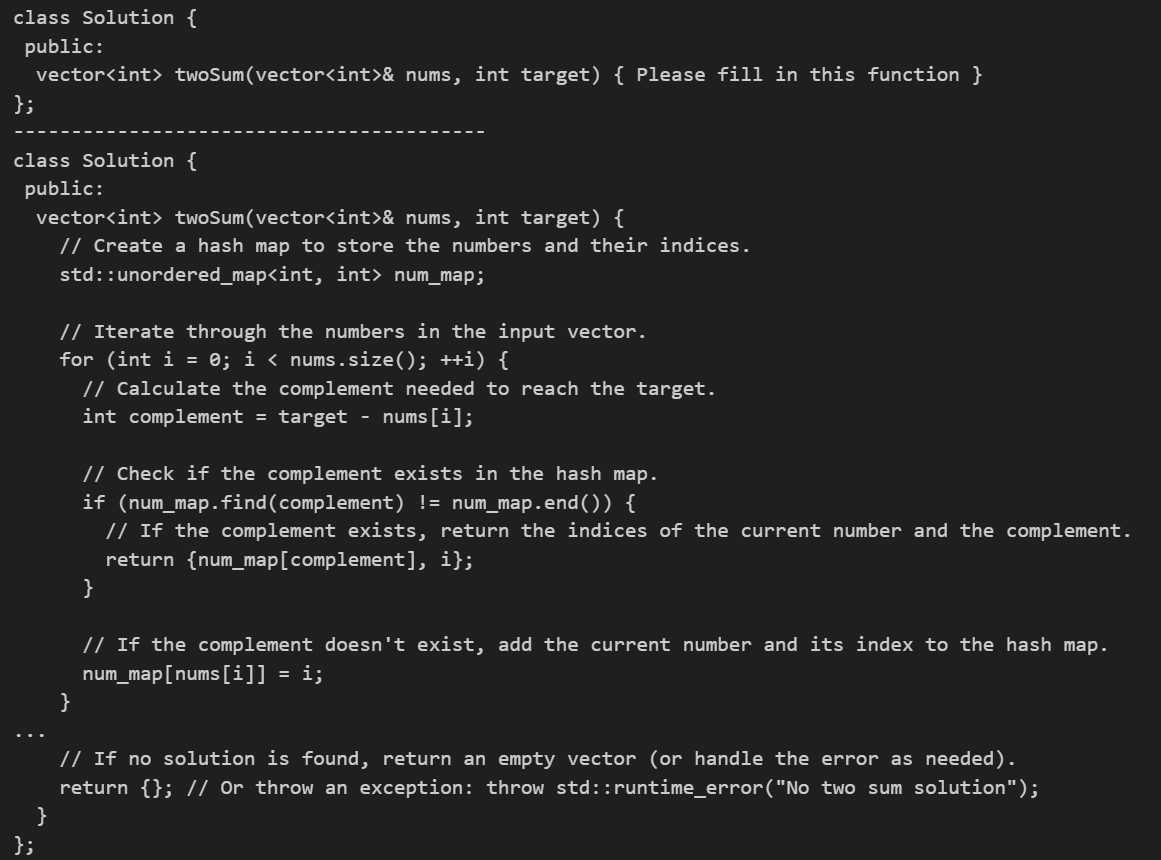

For example, the original prompt we used was `"In the following code snippet, give the C++ implementation where it says \"Please fill in this function\" in the appropriate C++ implementation. Do not generate additional text.\n" + code_snippet` (We didn't notice that we told it C++ implementation twice but it started generating and it was too late then).

Still, the first time w/ that prompt it worked correctly, leaving the class and function headers intact. Trying this again on a different day, Gemini simply gave the code to be put into the function.

The important thing is that the queries can vary and you need to tweak them. You can test it below.

In [9]:
print(function_headers[0])

# Generate the AI code for the first snippet to verify it is in the format we want it.
ai_code = llm.generate_content(prompt + function_headers[0])
print("-----------------------------------------")
print(ai_code)

class Solution {
 public:
  vector<int> twoSum(vector<int>& nums, int target) { Please fill in this function }
};
-----------------------------------------
class Solution {
 public:
  vector<int> twoSum(vector<int>& nums, int target) {
    std::unordered_map<int, int> numMap; // Use a hash map for efficient lookup
    for (int i = 0; i < nums.size(); ++i) {
      int complement = target - nums[i];
      if (numMap.find(complement) != numMap.end()) {
        return {numMap[complement], i}; // Found the complement! Return indices.
      }
      numMap[nums[i]] = i; // Store the number and its index in the map
    }
    return {}; // No solution found.  Returning an empty vector indicates this.
  }
};


Next is the part that takes a lot of time, due to the rate limiting. We don't recommend doing this unless you really want to generate your own dataset again. Skip to step 2.b if you don't want to sit here for a while.

In [ ]:
# Generate the AI code for all the function headers
# We will store the AI generated code in a new row, and then concatenate it with the original dataframe
for i,code in enumerate(function_headers):
    generated_code = llm.generate_content(prompt + code)
    
    ## Uncomment the following line to see the generated code for each row
    ## print("Generated code for row " + str(i) + ":\n" + generated_code + "\n")
    
    ## Put the data in a new row, and append it to the dummy dataframe
    new_row = np.concatenate((generated_code, [1]), axis=None) 

    ai_data = pd.concat([ai_data, pd.DataFrame([new_row], columns=ai_data.columns)], ignore_index=True)

# Save the AI generated data to a CSV file so we don't have to run the model again.    
ai_data.to_csv('data_ai_no_metrics.csv', index=False)

##### What to do if Google says your quota has been fulfilled and your code stops mid execution.
Save the data (using the code cell below to print or pickle or however you want to save it) and tweak the code to start again from the iteration you left off of. (Check the Jupyter variables for the value of i).

In [ ]:
# When you rerun the cell 2.a, make sure to start from the iteration where you left off.
# For example, if you only got 10 requests, then start from 11.
# Otherwise you would be getting LLM generated code for the same tasks repeatedly.

ai_data.to_csv('temp_ai_data.csv', index=False, mode='a')

#### 2.b After you have generated AI code data, read it and merge with human sample data.
Lets read our data and check if it is how we want it to be!

In [10]:
# Try to read the data from the csv file, if it exists
# Read the data from the csv file, if you're doing this from scratch it would be whatever files you saved the data to in the previous steps.
# We already have the data generated, so we will use the data we have in the dataset folder
try:
    data_ai = pd.read_csv('dataset/cleaned_data_ai_no_metrics.csv')
    data_human = pd.read_csv('dataset/cleaned_data_human_no_metrics.csv')
except:
    print("One or more data files not found. Please make sure the data file is in the same directory as this script. or run the data generation script first.")

In [11]:
data_human.head()

,Answer,ai_generated
0,class Solution {\r\n public:\r\n vector<int> ...,0
1,class Solution {\r\n public:\r\n ListNode* ad...,0
2,class Solution {\r\n public:\r\n int lengthOf...,0
3,class Solution {\r\n public:\r\n double findM...,0
4,class Solution {\r\n public:\r\n string longe...,0


In [12]:
data_ai.head()

,Answer,ai_generated
0,class Solution {\r\n public:\r\n vector<int> ...,1
1,class Solution {\r\n public:\r\n ListNode* ad...,1
2,class Solution {\r\n public:\r\n int lengthOf...,1
3,class Solution {\r\n public:\r\n double findM...,1
4,class Solution {\r\n public:\r\n string longe...,1


Looks good, combine into a single dataset.

In [13]:
data_combined = pd.concat([data_human, data_ai], ignore_index=True)

# saved the combined data to a file so we don't have to redo this entire process again
data_combined.to_csv('cleaned_data_cpp_combined.csv', index=False)

data_combined.head()


,Answer,ai_generated
0,class Solution {\r\n public:\r\n vector<int> ...,0
1,class Solution {\r\n public:\r\n ListNode* ad...,0
2,class Solution {\r\n public:\r\n int lengthOf...,0
3,class Solution {\r\n public:\r\n double findM...,0
4,class Solution {\r\n public:\r\n string longe...,0


Check the tail end aswell to see if the ai generated ones were correctly concatenated!

In [14]:
data_combined.tail()

,Answer,ai_generated
3003,class Solution {\r\n public:\r\n int numberOf...,1
3004,class Solution {\r\n public:\r\n int numberOf...,1
3005,class Solution {\r\n public:\r\n int firstDay...,1
3006,class UnionFind {\r\n public:\r\n UnionFind(i...,1
3007,class Solution {\r\n public:\r\n int findInte...,1


## 3-5. Tokenize all code samples, train a Doc2Vec model, convert code samples to vectors to be used in model training.

We now have our full dataset of AI generated and human generated code samples. We now need to get them into a format that an ML model can use, a vector of numbers.

We want these vectors to be distributed, continuous, and have similarity which reflects the semantic/syntactic similarity of the original code.

An accessible approach is to train a Word2Vec based model, which produces vectors with those properties when given a large amount of input text containing the words or sentences you want it to learn. We elect to use Doc2Vec, which applies Word2Vec to documents, as we want to compare the similarity of entire snippets of code for now.

Word2Vec and its derived models have the issue of "breaking" when given a word or symbol that they weren't trained on, so you want to use a very large corpus of examples with varied texts. 

For our research question however, we are working with code, not natural language text. Variable and function names in code have different variation in them than natural language words. The same variable depending on preference, style, etc can be written in many ways and so with Doc2Vec its possible we fail to encode variables due to this.

```c++
ex
example
_ex
__ex
ex_1
ex_0
x_0
x_1
x0
...
// so on so forth
```

So our approach will be to simply use all of the code samples to train the Doc2Vec encoding, and use the encodings Doc2Vec gives to train an ML model. 

In [15]:
from encoding import cpp_tokenize, token_to_string, create_tagged_documents, train_doc2vec_model, encode

# Read combined data from the csv file you stored your combined data to, in our case it is 'cleaned_data_cpp_combined.csv'
data_combined = pd.read_csv('cleaned_data_cpp_combined.csv')

print(data_combined['Answer'][0])
# Tokenize the C++ code samples with SCT 
sct_token_samples = cpp_tokenize(data_combined['Answer'])
print(sct_token_samples[0])

# Convert the SCT Token objects to strings
str_code_tokens = token_to_string(sct_token_samples)
print(str_code_tokens[0])

# Create tagged documents for the Doc2Vec model
tagged_documents = create_tagged_documents(str_code_tokens)
print(tagged_documents[0])
# Train the Doc2Vec model, save it to "doc2vec.model".
# If the model file already exists, it will load the existing model.
doc2vec = train_doc2vec_model(tagged_documents, "doc2vec")

# Take the simple token strings and encode them using the trained Doc2Vec model
encoded_samples = encode(str_code_tokens, doc2vec)

# Combine the encoded samples with the original data
model_data = pd.concat([encoded_samples, data_combined["ai_generated"]], axis=1)
model_data.head()

class Solution {
 public:
  vector<int> twoSum(vector<int>& nums, int target) {
    unordered_map<int, int> numToIndex;

    for (int i = 0; i < nums.size(); ++i) {
      if (const auto it = numToIndex.find(target - nums[i]);
          it != cend(numToIndex))
        return {it->second, i};
      numToIndex[nums[i]] = i;
    }

    throw;
  }
};
[(class, TokenType.KEYWORD, (1, 1)), (Solution, TokenType.IDENTIFIER, (1, 7)), ({, TokenType.SPECIAL_SYMBOL, (1, 16)), (public, TokenType.KEYWORD, (2, 2)), (:, TokenType.OPERATOR, (2, 8)), (vector, TokenType.IDENTIFIER, (3, 3)), (<, TokenType.OPERATOR, (3, 9)), (int, TokenType.KEYWORD, (3, 10)), (>, TokenType.OPERATOR, (3, 13)), (twoSum, TokenType.IDENTIFIER, (3, 15)), ((, TokenType.SPECIAL_SYMBOL, (3, 21)), (vector, TokenType.IDENTIFIER, (3, 22)), (<, TokenType.OPERATOR, (3, 28)), (int, TokenType.KEYWORD, (3, 29)), (>, TokenType.OPERATOR, (3, 32)), (&, TokenType.OPERATOR, (3, 33)), (nums, TokenType.IDENTIFIER, (3, 35)), (,, TokenType.OPERATOR,

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,ai_generated
0,0.048805,-0.210782,0.684499,1.227585,0.459164,0.301122,-0.438963,0.680142,-0.587715,0.334593,...,0.717939,-0.146900,-0.028423,0.553371,0.095439,-0.913604,0.194827,-1.503777,1.031114,0
1,0.041339,-0.139396,0.843212,-0.007606,1.299294,0.007257,-0.228266,0.233199,0.961727,-0.432524,...,-0.125989,-0.135812,-0.196293,0.529441,-0.242434,1.188189,-0.799082,0.082654,-0.169811,0
2,-0.285864,-0.625746,0.464747,0.364487,0.580997,0.312922,0.610805,-0.064928,0.773265,0.131404,...,0.703468,0.385979,-0.869251,1.690773,-0.034218,0.220643,-0.848538,-0.767002,1.415661,0
3,-0.211491,0.772247,-0.214511,1.018408,0.518855,-0.081882,-0.182149,0.557859,-0.054465,-0.326820,...,1.466458,-0.123857,0.273318,1.111010,1.337389,-0.634244,-0.770004,0.030071,-0.055037,0
4,-0.347005,-0.321403,-0.375077,0.257749,0.863504,0.395867,-0.613485,0.846517,-0.132868,0.453719,...,0.440424,0.156069,1.185128,-0.365702,1.043728,-0.405909,-0.755577,1.037394,0.104820,0


Now we have a dataset of numeric values, 300 features and 1 class label. 0 denotes human generated and 1 denotes AI generated.

### 6. Training a Classifier

Now that we have both the human and AI generated code encoded into vectors and labeled, we can use a classifier.

We will first show it with XGBoost, a machine learning paradigm that uses gradient boosting to train an ensemble of weak models which together have very good classification capability.

Later we will show how this generalizes to RandomForest, and Support Vector Machine based approaches

The first step is to split our data into training, validation, and test sets with a (75%, 12.5%, 12.5%) split.

We use the training set to train the model, validation to tweak the models hyperparameters, and then the final test of its accuracy is on the test set.

Fitting 25 folds for each of 1 candidates, totalling 25 fits
0.21843949799756726
{'eta': 0.3, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 1000}
[[ 28 151]
 [162  35]]
1233    0
1884    1
162     0
1629    1
1539    1
       ..
549     0
80      0
2127    1
1128    0
1404    0
Name: ai_generated, Length: 376, dtype: int64
[1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0
 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1
 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1
 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1
 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1
 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1

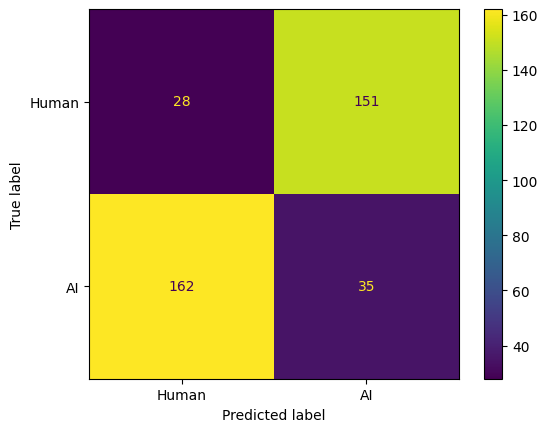

In [ ]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import cupy --- for those with NVIDIA GPUs and CUDA installed this can speed up the training process


## Split the data into training and testing sets
X = model_data.drop(columns=['ai_generated'])
y = model_data['ai_generated']
train = model_data.sample(frac=0.75,random_state=200)
remaining = model_data.drop(train.index)
## ONLY USE THE VALIDATION SET FOR MODEL/HYPERPARAMETER TUNING
validate = remaining.sample(frac=0.5, random_state=200)
## DO NOT USE THIS TEST SET FOR TUNING OR TRAINING, ONLY FOR FINAL EVALUATION
test = remaining.drop(validate.index)


X_train = train.drop(columns="ai_generated").to_numpy()
y_train = train['ai_generated']
X_val = validate.drop(columns="ai_generated").to_numpy()
y_val = validate['ai_generated']
X_test = test.drop(columns="ai_generated").to_numpy()
y_test = test['ai_generated']


## Train a XGB Classifier

kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
xgb_model = XGBClassifier(n_jobs = 4, tree_method="hist", random_state=42)


## Use GridSearchCV to find the best hyperparameters, only using the training set. This takes a really long time the more hyperparameters combinations you have.
## Currently set to only use the default because it takes too long to run.
## You can add more hyperparameters to the dictionary to search through more combinations.

clf = GridSearchCV(xgb_model, {'n_estimators': [1000], 'eta': [.3], 'min_child_weight': [2], 'max_depth': [8]}, cv=kf, verbose=1, scoring="precision")
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

y_pred = clf.predict(X_val)

print(confusion_matrix(y_val, y_pred))

print(y_val)
print(y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=["Human", "AI"])
disp.plot()

Notice that, it has really bad accuracy. 

At first, we thought we thought it's because the default hyperparameters weren't suited for our prediction 

So we decided to do a hyperparameter search with KFold GridSearchCV and using the following code. (added cupy to use GPUs because it would take too long on a CPU.)

```python

kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

xgb = XGBClassifier(n_jobs = 4, tree_method="hist", device="cuda", random_state=42)

clf = GridSearchCV(xgb, {'n_estimators': [50, 100, 200, 500, 800, 1000], 'eta': [.07, .14, .21, .3], 'min_child_weight': [0, .1, .5, 1, 2], 'max_depth': [1,2,4]}, cv=kf, verbose=1, scoring="precision")
clf.fit(cupy.array(train.drop(columns="ai_generated").to_numpy()), train['ai_generated'])
print(clf.best_score_)
print(clf.best_params_)

y_pred = clf.predict(validate.drop(columns="ai_generated"))

print(confusion_matrix(validate["ai_generated"], y_pred))
```

This gave

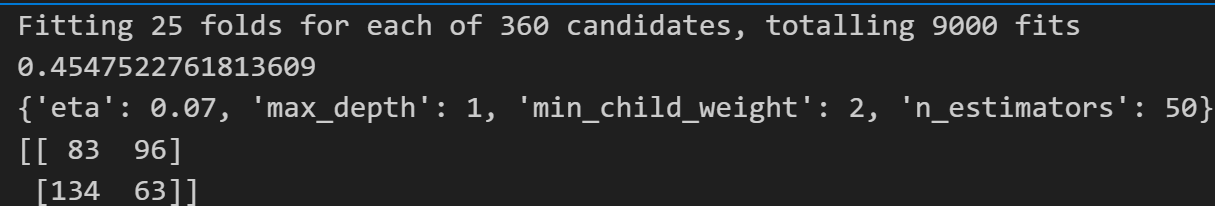

But that's was actually worse, because now the entire confusion matrix had similar counts. The model is essentially predicting randomly. 

Thank you to Prof. LePendu who told us about the sensitivity vs 1-specificity curve and how theirs was flipped! In our case, our false positive rate was high and our true positive rate was low and the same held for the true and false negatives. We realized then that if we tell the model to predict the opposite label, it would be what we wanted (high true negative and positive rates, low false negative and false positive rates).

Let us generate some ROC curves to see this.

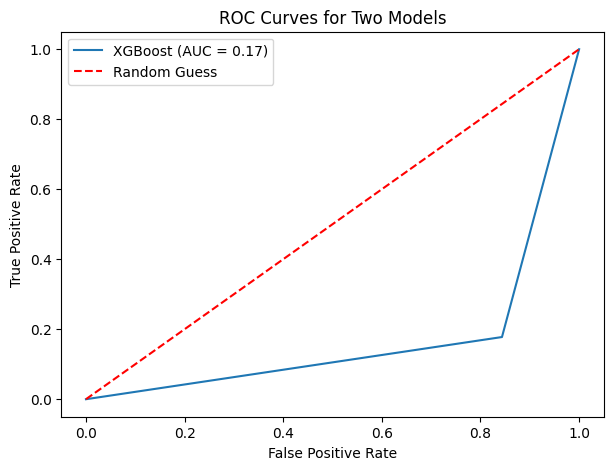

In [17]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{"XGBoost"} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

See, the curve is hugging the bottom of the graph, so for the validation set, it is predicting Human when it should predict AI and then its predicting AI when it should predict human!

We flip the labels!

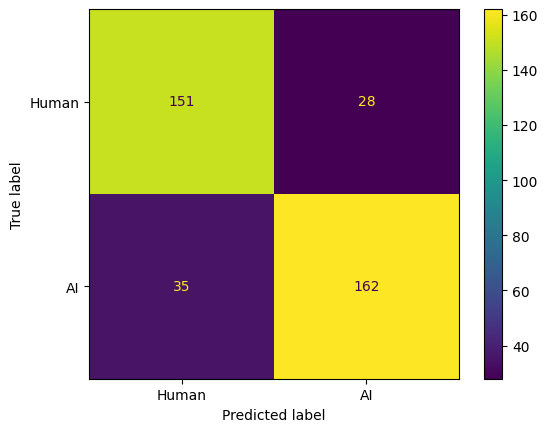

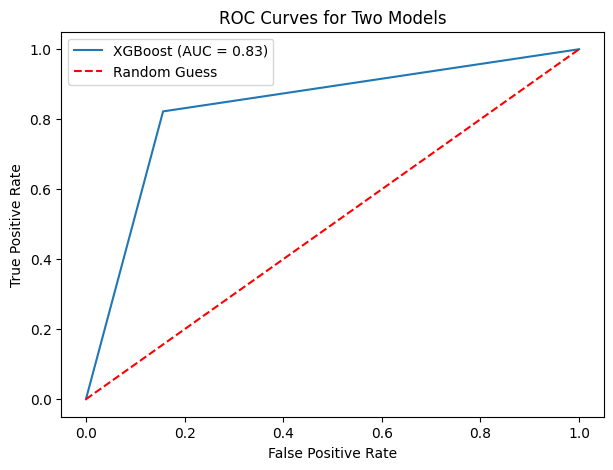

In [18]:
flipped_labels = 1 - y_pred

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(validate["ai_generated"], flipped_labels), display_labels=["Human", "AI"])

disp.plot()

plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_val, flipped_labels)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{"XGBoost"} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()


Much better! Here are some classification metrics for the validation set

Alongside the standard accuracy, precision, recall, true/false positive/negative rates, we also decided to look at markedness.

Markedness is a measurement used in linguistics and social sciences which shows how something might deviate from a possible norm. [https://en.wikipedia.org/wiki/Markedness] 

We think that would be a good metric to possibly apply here, given that we want to show how AI generated code deviates from the human norm, if it can be differentiated in that way.

In [19]:

tn, fp, fn, tp = confusion_matrix(y_val, 1-y_pred).ravel()


accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
markedness = (tp / (tp + fp)) + (tn / (tn + fn)) - 1


print("Accuracy: ", (tp + tn) / (tp + tn + fp + fn))
print("Precision: ", tp / (tp + fp))
print("Recall: ", tp / (tp + fn))
print("True Positive Rate: ", tp / (tp + fn))
print("True Negative Rate: ", tn / (tn + fp))
print("False Positive Rate: ", fp / (fp + tn))
print("False Negative Rate: ", fn / (fn + tp))
print("Markedness: ", (tp / (tp + fp)) + (tn / (tn + fn)) - 1)

## Let's put these values into a table for comparison

## Create a table for the results

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "True Positive Rate", "True Negative Rate", "False Positive Rate", "False Negative Rate", "Markedness"])

results = pd.concat([results, pd.DataFrame([["XGBoost", accuracy, precision, recall, tpr, tnr, fpr, fnr, markedness]], columns=results.columns)], ignore_index=True)

results.head()

Accuracy:  0.8324468085106383
Precision:  0.8526315789473684
Recall:  0.8223350253807107
True Positive Rate:  0.8223350253807107
True Negative Rate:  0.8435754189944135
False Positive Rate:  0.1564245810055866
False Negative Rate:  0.17766497461928935
Markedness:  0.6644595359366157


C:\Users\vahag\AppData\Local\Temp\ipykernel_16656\1036836276.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([["XGBoost", accuracy, precision, recall, tpr, tnr, fpr, fnr, markedness]], columns=results.columns)], ignore_index=True)


,Model,Accuracy,Precision,Recall,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Markedness
0,XGBoost,0.832447,0.852632,0.822335,0.822335,0.843575,0.156425,0.177665,0.66446


## 7. Compare ML models (ex: Random Forest (RF) and Support Vector Machine (SVM) ) (Muntaka)

Because everything above was done on the validation set, we will now train the best iteration of our models and compare few different algorithms on the test set we left out at the very beginning to see how it performs on entirely unseen data and whether the choice of ML algorithm any difference!

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

#### Random Forest Classifier

Random Forest Accuracy: 0.88


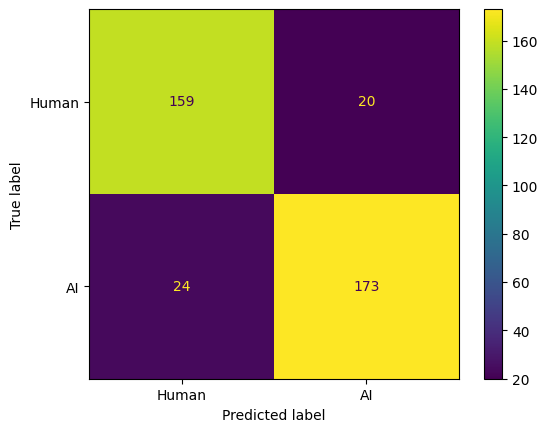

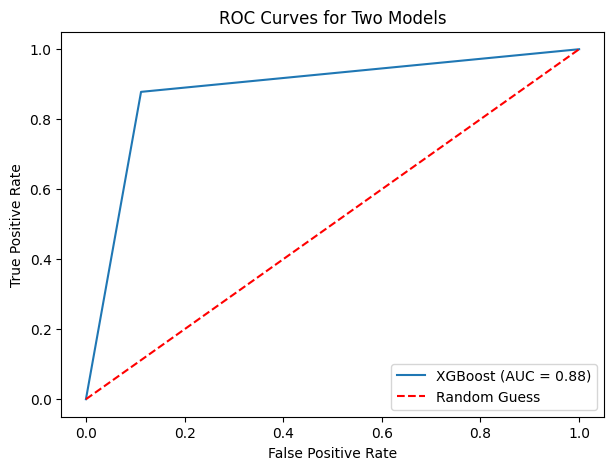

,Model,Accuracy,Precision,Recall,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Markedness
0,XGBoost,0.832447,0.852632,0.822335,0.822335,0.843575,0.156425,0.177665,0.664460
1,Random Forest,0.117021,0.131148,0.121827,0.121827,0.111732,0.888268,0.878173,-0.765226
2,Random Forest,0.882979,0.896373,0.878173,0.878173,0.888268,0.111732,0.121827,0.765226
3,Random Forest,0.882979,0.896373,0.878173,0.878173,0.888268,0.111732,0.121827,0.765226
4,Random Forest,0.882979,0.896373,0.878173,0.878173,0.888268,0.111732,0.121827,0.765226


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
## flip the labels
rf_preds = 1 - rf_preds


rf_acc = accuracy_score(y_val, rf_preds)
print(f"Random Forest Accuracy: {rf_acc:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, rf_preds), display_labels=["Human", "AI"])
disp.plot()

plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_val, rf_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{"XGBoost"} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

tn, fp, fn, tp = confusion_matrix(y_val, rf_preds).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
markedness = (tp / (tp + fp)) + (tn / (tn + fn)) - 1

results = pd.concat([results, pd.DataFrame([["Random Forest", accuracy, precision, recall, tpr, tnr, fpr, fnr, markedness]], columns=results.columns)], ignore_index=True)

results.head()

Same issue, flip.

#### Support vector machine(SVM)

SVM Accuracy (Default): 0.24
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy (Best): 0.48


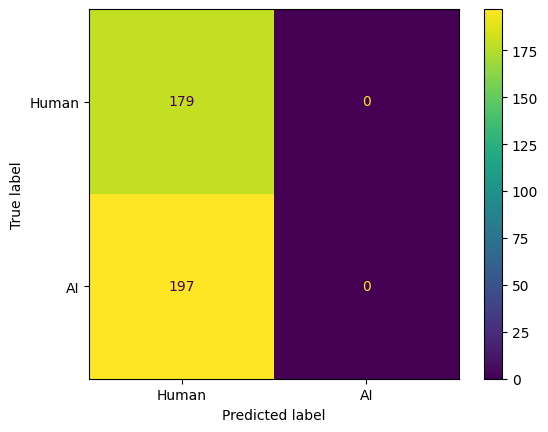

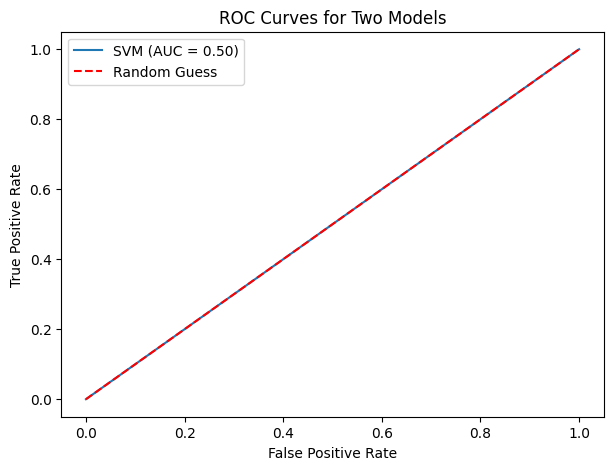

C:\Users\vahag\AppData\Local\Temp\ipykernel_16656\3303620022.py:56: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\vahag\AppData\Local\Temp\ipykernel_16656\3303620022.py:62: RuntimeWarning: invalid value encountered in scalar divide
  markedness = (tp / (tp + fp)) + (tn / (tn + fn)) - 1


,Model,Accuracy,Precision,Recall,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Markedness
0,XGBoost,0.832447,0.852632,0.822335,0.822335,0.843575,0.156425,0.177665,0.664460
1,Random Forest,0.117021,0.131148,0.121827,0.121827,0.111732,0.888268,0.878173,-0.765226
2,Random Forest,0.882979,0.896373,0.878173,0.878173,0.888268,0.111732,0.121827,0.765226
3,Random Forest,0.882979,0.896373,0.878173,0.878173,0.888268,0.111732,0.121827,0.765226
4,Random Forest,0.882979,0.896373,0.878173,0.878173,0.888268,0.111732,0.121827,0.765226


In [27]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_val)
svm_acc = accuracy_score(y_val, svm_preds)
print(f"SVM Accuracy (Default): {svm_acc:.2f}")

# Hyperparameter Tuning with GridSearchCV (Regularization parameter 'C' and Kernel coefficient 'gamma')
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold Cross Validation
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best Parameters for SVM: {best_params}")

best_svm = SVC(**best_params, random_state=42)
best_svm.fit(X_train, y_train)


best_svm_preds = best_svm.predict(X_val)
best_svm_acc = accuracy_score(y_val, best_svm_preds)
print(f"SVM Accuracy (Best): {best_svm_acc:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, best_svm_preds), display_labels=["Human", "AI"])
disp.plot()

plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_val, best_svm_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{"SVM"} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

tn, fp, fn, tp = confusion_matrix(y_val, best_svm_preds).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
markedness = (tp / (tp + fp)) + (tn / (tn + fn)) - 1

results = pd.concat([results, pd.DataFrame([["SVM", accuracy, precision, recall, tpr, tnr, fpr, fnr, markedness]], columns=results.columns)], ignore_index=True)

results.head()

## 7. Gather metrics for each model on the actual test set (Muntaka)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [33]:
def evaluate_model(model, X_test, y_test):

    tn, fp, fn, tp = confusion_matrix(y_test, 1- model.predict(X_test)).ravel()
    
    acc = accuracy_score(y_test, 1 - model.predict(X_test))
    precision = precision_score(y_test, 1 - model.predict(X_test))
    recall = recall_score(y_test, 1- model.predict(X_test))
    f1 = f1_score(y_test, 1- model.predict(X_test))

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    markedness = (tp / (tp + fp)) + (tn / (tn + fn)) - 1


    return acc, precision, recall, f1, tpr, fpr, tnr, fnr, markedness

In [34]:
rf_results = evaluate_model(rf_model, X_test, y_test)
xgb_results = evaluate_model(xgb.fit(X_train, y_train), X_test, y_test)
svm_results = evaluate_model(svm_model, X_test, y_test)

pd.DataFrame([rf_results, xgb_results, svm_results], columns=["Accuracy", "Precision", "Recall", "F1 Score", "True Positive Rate", "False Positive Rate", "True Negative Rate", "False Negative Rate", "Markedness"], index=["Random Forest", "XGBoost", "SVM"])

,Accuracy,Precision,Recall,F1 Score,True Positive Rate,False Positive Rate,True Negative Rate,False Negative Rate,Markedness
Random Forest,0.797872,0.763285,0.854054,0.806122,0.854054,0.256545,0.743455,0.145946,0.603522
XGBoost,0.784574,0.785714,0.772973,0.779292,0.772973,0.204188,0.795812,0.227027,0.569219
SVM,0.752660,0.739583,0.767568,0.753316,0.767568,0.261780,0.738220,0.232432,0.505888
